# Linear Regression 
NY Taxi Cab Trip Duration 

# References

## Linear Regression Model on the New York Taxi Trip Duration Dataset using Python
* https://medium.com/analytics-vidhya/building-a-linear-regression-model-on-the-new-york-taxi-trip-duration-dataset-using-python-2857027c54f3

# Linear Regression Data Science Process

Process:
1. EDA (previous noteboook)
  1. Goals and Objectives
  2. Load the Data
  3. Detailed Data analysis  
    a. Uni-Variate Analysis  
    b. Bi-Variate Analysis  
  4. Conclusions
2. REGRESSION MODEL (this notebook) 
  1. Goals and Objectives
  2. Load the Data
  * EDA (did this in the previous notebook
  3. Feature Extraction
    * Study Independent Variables for Predictability
    * Transform - aggregate, etc ...
  4. Regression Model (ML)
  5. Measure the model effectiveness

# 1. Problem Statement

Problem stateent:

* BUSINESS GOAL - A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is smooth and hassle free. One of main issue is determining the duration of the current trip so it can predict when the cab will be free for the next trip.
* TECHNICAL GOAL - build a regression model that estimates the duration of a taxi trip based on historic data
* This dataset and problem statement is taken from the Applied Machine Learning course by Analytics Vidhya 



# 2. Load the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [3]:
# before you begin provide your credentials to the runtime
#from google.colab import auth
#auth.authenticate_user()
#print('Authenticated')

#from google.cloud import bigquery
#project_id = 'alg-analytics-247823'
#client = bigquery.Client(project=project_id)

In [3]:
# https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c
#from google.colab import drive
#drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [5]:
# import the data
# look at the columns with df.head()

df = pd.read_csv('./nyc_taxi_train_2016.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# 3. Feature Extraction

analyze, transorm, prepare variables for prediction

### Trip Duration

Look at the largest and smallest occurring Trip_Duration values.

In [6]:
print('The value of largest 5 trip duration values are as follows : \n {} '.format(df['trip_duration'].nlargest(100)))
print('\nThe the number of rows with 1 as their trip duration values is {}'.format(len(df[df['trip_duration']==1 ])))

The value of largest 5 trip duration values are as follows : 
 978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
            ...   
1207527      86340
1208107      86340
91111        86339
408368       86339
424008       86339
Name: trip_duration, Length: 100, dtype: int64 

The the number of rows with 1 as their trip duration values is 33


We see that there is 1 very large value and 13 values with 1 second as its duration which is absurd. Hence we are dropping these rows.

In [7]:
df=df[df.trip_duration!=df.trip_duration.max()]
df=df[df.trip_duration!=df.trip_duration.min()]

We will now create another column with the trip_duration represented in hours. This will be later used for finding out the speed of each trips

In [8]:
df['trip_duration_hour']=df['trip_duration']/3600 

### Passenger Count

Look at the passenger count frequencies

In [9]:
df.passenger_count.value_counts()

1    1033508
2     210317
5      78088
3      59896
6      48333
4      28404
0         59
7          3
9          1
8          1
Name: passenger_count, dtype: int64

Here, the no of records with passenger count 0,9 and 7 are very small compared to the entire data set. Hence, we will drop the values.

In [10]:
df=df[df.passenger_count<=6]
df=df[df.passenger_count!=0]

### Pickup_datetime and Dropoff_datetime

We already converted these 2 columns into datetime type in the EDA Notebook. Now we create new columns depicting the month and day of the week the particular trip took place.

In [11]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

Look at the distribution of the pickup and drop off months distributions

In [12]:
df['pickup_month'].value_counts()

3    256174
4    251627
5    248472
2    238281
6    234308
1    229684
Name: pickup_month, dtype: int64

In [12]:
df['dropoff_month'].value_counts()

3    256119
4    251618
5    248540
2    238274
6    234235
1    229633
7       127
Name: dropoff_month, dtype: int64

All the months has uniform distribution of trips.No data is present for pickup months beyond June. There are few data present in July for drop off months. It may be outlier as well. We will have to look into that.

For the drop offs done in July we will find the frequency distribution of the corresponding pickup month. We find the corresponding date as well.

In [13]:
print(df[df.dropoff_month==7].pickup_datetime.dt.month.value_counts())

print(df[df.dropoff_month==7].pickup_datetime.dt.day.value_counts())

6    127
Name: pickup_datetime, dtype: int64
30    127
Name: pickup_datetime, dtype: int64


Thus we see that all the pickups were done on 30th June for drop offs on July. So the data seems fine.

### Trip Distance, Speed, Time

Create a function which returns the distance between a pair of latitudes and longitudes using the haversine distance formula.

In [14]:
#a function is created to calculate the distance from latitudes and longitudes
from math import radians, cos, sin, asin, sqrt
def haversine(df):
    lat1, lon1, lat2, lon2 = df.pickup_latitude,df.pickup_longitude,df.dropoff_latitude,df.dropoff_longitude 
    R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    return R * c

Apply this function to each of the rows and create a new feature distance which stores the distance between the pickup and dropoff points in kilometers.

In [15]:
df['distance'] = df.apply(lambda x: haversine(x), axis = 1)

We will have a look at the distribution of this distance feature against the trip_duration value.

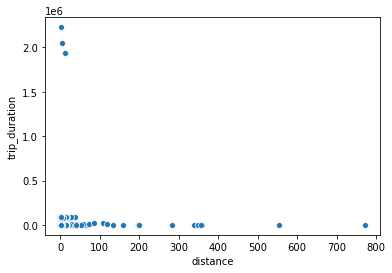

In [16]:
sns.scatterplot(x='distance',y='trip_duration',data=df)

We see several outliers with values much beyond 200km and many values with trip_distance = 0km. These may be the rows depicting cancelled rides. Lets have a look at how many such rides are there.

In [17]:
print('No. of rows with distance =0 are {}'.format(len(df[df.distance==0])))

No. of rows with distance =0 are 5876


That’s quite a number! We will not drop these rows. Rather we will replace these datas with the average distance

MAYBE SHOULD REPLACE w DISTANCE CORRESPONDING TO AVG VELOCITY

In [18]:
mean_dist=df['distance'].mean()
df.loc[df['distance']==0,'distance']=mean_dist

Create a new feature called speed. This will help us in identifying data points where time taken and distance covered does not match up. We will also have a look at the distribution of trip speed.

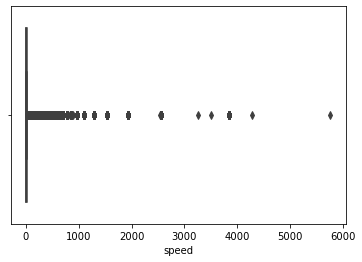

In [19]:
df['speed']=df['distance']/df['trip_duration_hour']
sns.boxplot(df['speed'])

Here we see several outliers. The average speed of a taxi in New York City is about 11 km/hour. The data has several data points with a speed way beyond that.


We will now have a look at the distribution of the distance variable against the trip duration in hour feature.

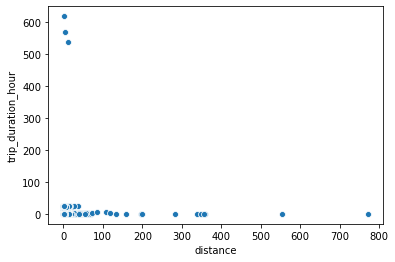

In [20]:
sns.scatterplot(x='distance',y='trip_duration_hour',data=df)

Here we see several data points where the distance is < 20 km and the time taken to be >10 hours. This is very absurd as the avg speed is 11 km/hour.

These might be due to extreme road congestion. Lets log transform these columns and have a look at the distribution again.

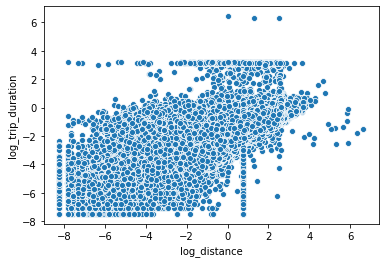

In [21]:
df['log_distance']=np.log(df.distance)
df['log_trip_duration']=np.log(df.trip_duration_hour)
sns.scatterplot(x='log_distance',y='log_trip_duration',data=df)

Here we see that the log transformed value of trip duration and distance has a somewhat linear relationship. But still there are some anomalous data points where the duration value is not changing even with the change in distance.


We will thus drop the rows beyond log_trip_duration > 2

In [22]:
df=df[df.log_trip_duration<2]

Since we have added several columns to our data set right now lets have a look at them.

In [23]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'trip_duration_hour', 'pickup_day', 'dropoff_day',
       'pickup_month', 'dropoff_month', 'distance', 'speed', 'log_distance',
       'log_trip_duration'],
      dtype='object')

We won’t use all of them to build our model as this would make the model very complex. We create a new data frame data2 to select only the features which had some effect on the target variable trip_duration.

We dropped certain features as they were transformed to other features. We dropped the nominal features as well.
eg: latitude longitudes were converted to distance,pickup and drop off datetime were converted corresponding months and weekdays etc.

In [24]:

def timewindow(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
df['pickup_timezone']=df['pickup_datetime'].apply(lambda x :timewindow(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

df['dropoff_timezone']=df['dropoff_datetime'].apply(lambda x :timewindow(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

In [25]:
data2=df[['passenger_count','store_and_fwd_flag','trip_duration', 'pickup_day', 'dropoff_day', 'pickup_month',
         'dropoff_month','pickup_timezone','dropoff_timezone','speed','log_distance','distance']]

Transform the categorical features from data2 dataframe through one hot encoding.

In [26]:
data2=pd.get_dummies(data2,columns=['store_and_fwd_flag','pickup_day','dropoff_day','pickup_month','dropoff_month','pickup_timezone', 'dropoff_timezone'])
data2.columns


Index(['passenger_count', 'trip_duration', 'speed', 'log_distance', 'distance',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'pickup_day_Friday',
       'pickup_day_Monday', 'pickup_day_Saturday', 'pickup_day_Sunday',
       'pickup_day_Thursday', 'pickup_day_Tuesday', 'pickup_day_Wednesday',
       'dropoff_day_Friday', 'dropoff_day_Monday', 'dropoff_day_Saturday',
       'dropoff_day_Sunday', 'dropoff_day_Thursday', 'dropoff_day_Tuesday',
       'dropoff_day_Wednesday', 'pickup_month_1', 'pickup_month_2',
       'pickup_month_3', 'pickup_month_4', 'pickup_month_5', 'pickup_month_6',
       'dropoff_month_1', 'dropoff_month_2', 'dropoff_month_3',
       'dropoff_month_4', 'dropoff_month_5', 'dropoff_month_6',
       'dropoff_month_7', 'pickup_timezone_evening',
       'pickup_timezone_late night', 'pickup_timezone_midday',
       'pickup_timezone_morning', 'dropoff_timezone_evening',
       'dropoff_timezone_late night', 'dropoff_timezone_midday',
       'dropoff_timezone_mo

### Correlation Heat Map

trip_duration                  1.000000
distance                       0.697019
log_distance                   0.695927
pickup_timezone_midday         0.063203
dropoff_timezone_midday        0.044790
pickup_day_Thursday            0.037656
dropoff_day_Thursday           0.036016
pickup_month_6                 0.034898
dropoff_month_6                0.034721
dropoff_month_5                0.031811
pickup_month_5                 0.031736
store_and_fwd_flag_Y           0.027153
dropoff_timezone_evening       0.026789
pickup_day_Wednesday           0.025871
dropoff_day_Wednesday          0.025742
pickup_day_Friday              0.019090
dropoff_day_Friday             0.018473
passenger_count                0.014840
pickup_day_Tuesday             0.011138
dropoff_day_Tuesday            0.010967
dropoff_month_7                0.009310
dropoff_month_4                0.007631
pickup_month_4                 0.007588
pickup_timezone_evening        0.006560
pickup_month_3                -0.013410


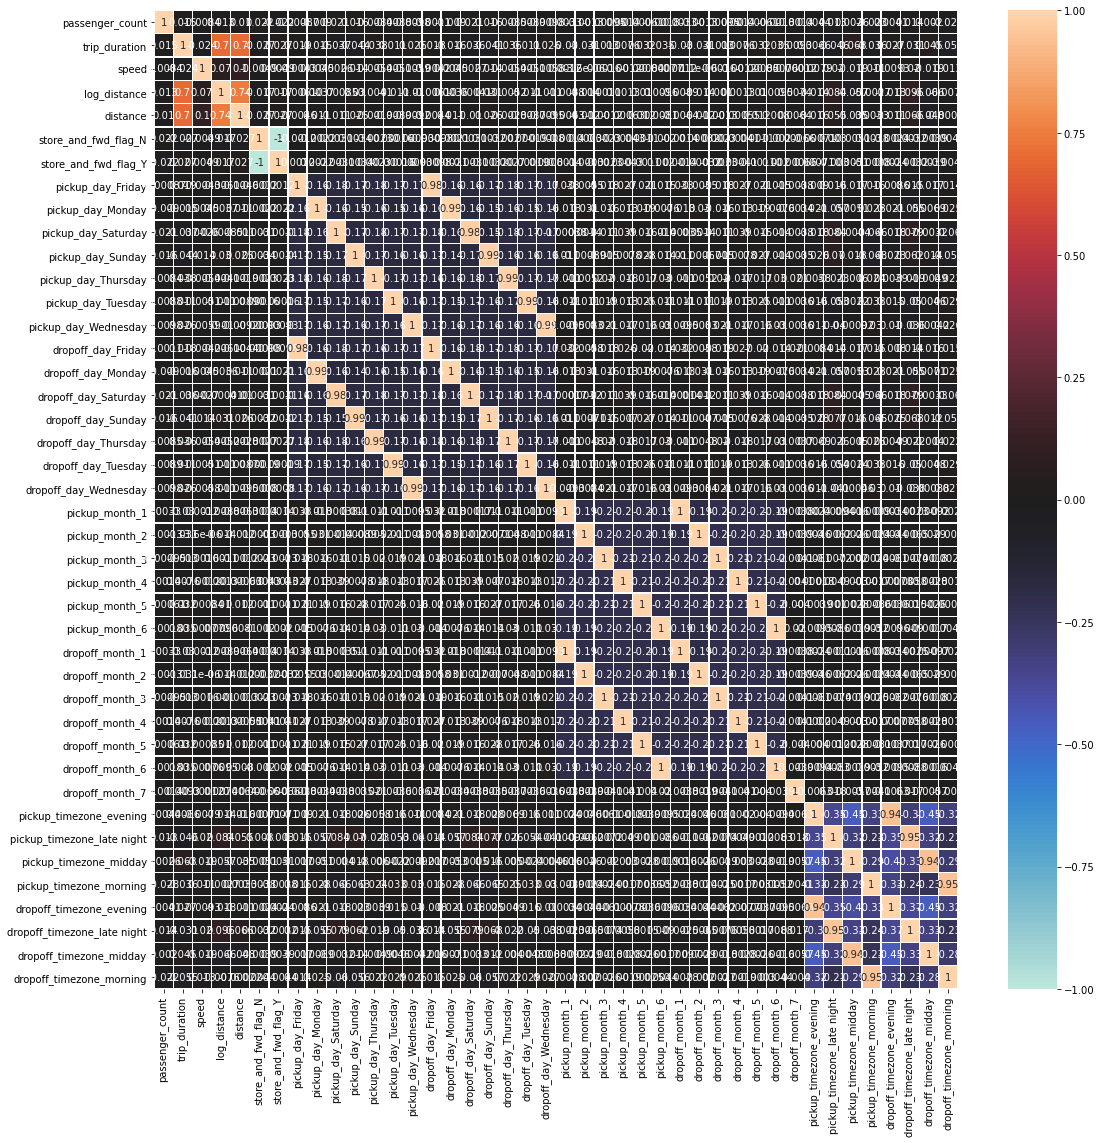

In [27]:
corr_matrix = data2.corr() 
fig, ax = plt.subplots(figsize=(18,18))   
print(corr_matrix["trip_duration"].sort_values( ascending = False))
cols=corr_matrix.columns
sns.heatmap(corr_matrix, center=0, annot=True, linewidths=.3, ax=ax)

Thus we see that some features has high correlation with other features and some are not correlated at all.

First we will create a model with the mean of trip duration as the prediction. Then we will create a base line model with only distance and it has a correlation > 5 with trip_duration. Next, we will choose the other features which are positively correlated with trip_duration and create the third model.

We will split our data into 2 parts. The first part we will use to train our data and the 2nd part will be used for testing.
Within the first part we will use K-Fold cross validation using this. (k=20)

We are defining the baseline model columns, columns to be used in the actual model building and the target column. 

We have removed the speed feature from the predictor columns as it highly correlated with distance and can lead to multicollinearity.

In [28]:
base_line_col=['distance']
predictor_cols=['passenger_count','distance','store_and_fwd_flag_N','store_and_fwd_flag_Y',
               'pickup_day_Friday','pickup_day_Monday','pickup_day_Saturday','pickup_day_Sunday',
               'pickup_day_Thursday','pickup_day_Tuesday','pickup_day_Wednesday','dropoff_day_Friday',
               'dropoff_day_Monday','dropoff_day_Saturday','dropoff_day_Sunday','dropoff_day_Thursday',
               'dropoff_day_Tuesday','dropoff_day_Wednesday','pickup_month_1','pickup_month_5','pickup_month_6',
               'dropoff_month_1','dropoff_month_5','dropoff_month_6','pickup_timezone_late night',
               'pickup_timezone_midday','pickup_timezone_morning','dropoff_timezone_evening',
               'dropoff_timezone_late night','dropoff_timezone_midday','dropoff_timezone_morning']
target_col=['trip_duration']

# 4. Linear Regression Model (ML)

Define a function which will take the model object, the test data, the train data, the predictor columns and the target columns. We will use Root Means Squared Error as the evaluation metric. More on that here.

The function will print out the RMSE of the train data, the average value of the RMSE at each fold of K-Fold cross validation and the test data. It will also return the predicted values on the test data. We have imported the required libraries.

In [29]:
from sklearn import  metrics
from sklearn.model_selection import cross_val_score
def modelfit(estimator,data_train,data_test,predictors,target):
    #print(data_train.head())
    #fitting model
    estimator.fit(data_train[predictors],data_train.loc[:,target])
    #train data prediction
    train_pred=estimator.predict(data_train[predictors])
    #cross_validation score
    cv_score=cross_val_score(estimator,data_train[predictors],data_train.loc[:,target],cv=20,scoring='neg_mean_squared_error')
    
    cv_score=np.sqrt(np.abs(cv_score))
    #Print model report:
    print ("\nModel Report")
    print ("RMSE on Train Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_train.loc[:,target].values, train_pred)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    test_pred=estimator.predict(data_test[predictors])
    print ("RMSE on Test Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_test.loc[:,target].values, test_pred)))
    
    
    
    return test_pred

Split the data into train and test data into 80:20 ratio

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
validation_size = 0.20
seed = 7
X_train, X_test = train_test_split(data2,test_size=validation_size, random_state=seed)

First create a model using the mean value as the predicted value and run it on the test data point.

In [31]:
mean_pred=np.repeat(X_train[target_col].mean(),len(X_test[target_col]))
from sklearn.metrics import mean_squared_error as mae
sqrt(mae(X_test[target_col],mean_pred))

665.3702902764425

The RMSE from this is 674.5795545337122. We will now use this value as the base and try to achieve a RMSE less than this.

Next we will take the distance feature as the only predictor columns and build a linear regression model. We will have a look at the RMSE obtained.

In [32]:
alg1 = LinearRegression(normalize=True)
print('The baseline model')
y_pred=modelfit(alg1, X_train, X_test,base_line_col,target_col)
coef1 = alg1.coef_
print('The coeffient is {}'.format(coef1))

The baseline model

Model Report
RMSE on Train Data: 486.4
CV Score : Mean - 484.3 | Std - 77.58 | Min - 434.2 | Max - 777.9
RMSE on Test Data: 450.3
The coeffient is [[170.16034579]]


# 5. Model Effectiness

R-Squared of the Baseline Model

In [33]:
from sklearn.metrics import r2_score
r2_score(X_test[target_col], y_pred, sample_weight=None, multioutput='uniform_average')

0.5419836169166656

As we can see, all the values are much less than the mean prediction RMSE. Thus our model worked better than simply taking the average. We printed the coefficient fitted to the model as well.

R-Squared not great ... R-Squred is the variability (variance) that explained by the model. Perfect is 1

Now we will take all the values of the predictor columns and build a regression model.


Model Report
RMSE on Train Data: 473
CV Score : Mean - 470.6 | Std - 79.61 | Min - 418.9 | Max - 771.5
RMSE on Test Data: 435.8


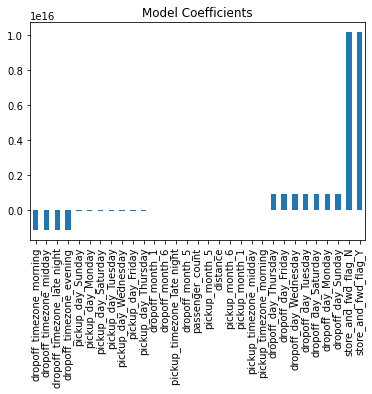

In [34]:
alg2 = LinearRegression(normalize=True)
y_pred=modelfit(alg2, X_train, X_test, predictor_cols,target_col)
coef1 = pd.Series(alg2.coef_[0], predictor_cols).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

R-Squared

In [35]:

r2_score(X_test[target_col], y_pred, sample_weight=None, multioutput='uniform_average')

0.5709671829426484

Plot the residuals to the assumption of Homoskedasticity ... variance does not change along the x axis. It is constant along the x-axis.

In [36]:
residuals=y_pred-X_test[target_col] #Heteroskedasticity
print(len(residuals))
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(residuals))
k = [0 for i in range(0,len(residuals))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()


291301


Here the distribution of the residuals is Homoscedastic. So the assumption of Linear Regression holds true.


That’s it for today. We will later explore more ways to improve our model and feature selection.

R-squared is not great